In [13]:
# Cell 1: Import Libraries and Set Up Logging
import logging
import os
import time
import gzip
import requests
from dotenv import load_dotenv
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log, when, median, to_date, coalesce, concat, lit
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, TimestampType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator, RankingEvaluator
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
import numpy as np
from datetime import datetime

In [14]:

# Configure logging
logging.basicConfig(
    filename='recommendation_pipeline.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'))
logging.getLogger().addHandler(console)

# Load environment variables
load_dotenv()
TMDB_API_KEY = os.getenv('TMDB_API_KEY')
TMDB_API_READ_ACCESS_TOKEN = os.getenv('TMDB_API_READ_ACCESS_TOKEN')

# Set HADOOP_HOME for Windows
os.environ["HADOOP_HOME"] = "C:\\hadoop-3.3.6"
os.environ["hadoop.home.dir"] = "C:\\hadoop-3.3.6"

# Stop any existing Spark sessions
spark = SparkSession.getActiveSession()
if spark:
    spark.stop()
    logging.info("Stopped existing Spark session")

# Initialize Spark session
os.environ["PYSPARK_PYTHON"] = os.path.abspath(".venv/Scripts/python.exe")

spark = SparkSession.builder \
    .appName("CostAwareRecommendation") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.pyspark.python", os.environ["PYSPARK_PYTHON"]) \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.port", "25334") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.driver.extraJavaOptions", "-Xss4m") \
    .config("spark.executor.extraJavaOptions", "-Xss4m") \
    .getOrCreate()
logging.info(f"Created Spark session: {spark.sparkContext.uiWebUrl}")

logging.info(
    "Spark session initialized, logging configured, and TMDb credentials loaded.")

2025-08-04 12:34:25,625 - INFO - Created Spark session: http://127.0.0.1:4040
2025-08-04 12:34:25,625 - INFO - Created Spark session: http://127.0.0.1:4040
2025-08-04 12:34:25,628 - INFO - Spark session initialized, logging configured, and TMDb credentials loaded.
2025-08-04 12:34:25,628 - INFO - Spark session initialized, logging configured, and TMDb credentials loaded.


In [4]:
# Cell 2: Fetch Budget Data from TMDb API
def fetch_tmdb_budgets(links_df):
    try:
        # Convert links to Pandas for API calls
        links_pd = links_df.select("movieId", "tmdbId").toPandas()
        links_pd = links_pd[links_pd['tmdbId'].notnull()]

        budgets = []
        base_url = "https://api.themoviedb.org/3/movie/"
        headers = {"Authorization": f"Bearer {TMDB_API_READ_ACCESS_TOKEN}"}

        logging.info(
            f"Fetching budgets for {len(links_pd)} movies from TMDb...")
        for idx, row in links_pd.iterrows():
            tmdb_id = str(int(row['tmdbId']))
            url = f"{base_url}{tmdb_id}?api_key={TMDB_API_KEY}"
            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                budgets.append({
                    'movieId': row['movieId'],
                    'tmdbId': tmdb_id,
                    'budget': data.get('budget', 0),
                    'release_date': data.get('release_date', '')
                })
            else:
                logging.warning(
                    f"Failed to fetch budget for tmdbId {tmdb_id}: {response.status_code}")

            # Respect rate limit (50 requests/sec < 0.03 sec/request)
            time.sleep(0.03)

            if (idx + 1) % 100 == 0:
                logging.info(f"Processed {idx + 1} movies...")

        # Save budgets as CSV
        budgets_df = pd.DataFrame(budgets)
        budgets_df.to_csv("tmdb_budgets.csv", index=False)

        # Convert to Spark DataFrame
        budgets_spark = spark.createDataFrame(budgets_df)
        logging.info(f"Fetched and saved {len(budgets)} budgets from TMDb.")
        return budgets_spark
    except Exception as e:
        logging.error(f"Failed to fetch TMDb budgets: {str(e)}")
        raise

In [5]:
def load_data_and_budgets():
    try:
        # Define schemas
        ratings_schema = StructType([
            StructField("userId", IntegerType(), False),
            StructField("movieId", IntegerType(), False),
            StructField("rating", FloatType(), False),
            StructField("timestamp", IntegerType(), False)
        ])
        movies_schema = StructType([
            StructField("movieId", IntegerType(), False),
            StructField("title", StringType(), False),
            StructField("genres", StringType(), True)
        ])
        links_schema = StructType([
            StructField("movieId", IntegerType(), False),
            StructField("imdbId", StringType(), True),
            StructField("tmdbId", StringType(), True)
        ])
        title_basics_schema = StructType([
            StructField("tconst", StringType(), False),
            StructField("titleType", StringType(), True),
            StructField("primaryTitle", StringType(), True),
            StructField("originalTitle", StringType(), True),
            StructField("isAdult", StringType(), True),
            StructField("startYear", StringType(), True),
            StructField("endYear", StringType(), True),
            StructField("runtimeMinutes", StringType(), True),
            StructField("genres", StringType(), True)
        ])

        # Load MovieLens data
        ratings_df = spark.read.schema(ratings_schema).csv(
            "ml-25m/ratings.csv", header=True)
        movies_df = spark.read.schema(movies_schema).csv(
            "ml-25m/movies.csv", header=True)
        links_df = spark.read.schema(links_schema).csv(
            "ml-25m/links.csv", header=True)

        # Load IMDb data
        basics_df = spark.read.schema(title_basics_schema).option(
            "delimiter", "\t").csv("imdb/title.basics.tsv.gz", header=True)

        # Check if budgets CSV exists
        budgets_path = os.path.abspath("tmdb_budgets.csv")
        if os.path.exists(budgets_path):
            logging.info("Loading budgets from existing CSV...")
            budgets_df = spark.read.csv(
                budgets_path, header=True, inferSchema=True)
        else:
            # Fetch TMDb budgets
            budgets_df = fetch_tmdb_budgets(links_df)
            # Ensure output directory exists
            os.makedirs(os.path.dirname(budgets_path), exist_ok=True)
            # Save budgets as CSV
            budgets_df.write.mode("overwrite").csv(budgets_path)

        # Format imdbId to match tconst (add 'tt' prefix)
        links_df = links_df.withColumn(
            "imdbId", concat(lit("tt"), col("imdbId")))

        logging.info("Loaded all datasets and budgets.")
        return ratings_df, movies_df, links_df, basics_df, budgets_df
    except Exception as e:
        logging.error(f"Failed to load data and budgets: {str(e)}")
        raise


# Check if DataFrames are already defined to avoid re-running
if 'ratings_df' not in globals() or 'movies_df' not in globals() or \
   'links_df' not in globals() or 'basics_df' not in globals() or \
   'budgets_df' not in globals():
    ratings_df, movies_df, links_df, basics_df, budgets_df = load_data_and_budgets()
else:
    logging.info("DataFrames already loaded, skipping load_data_and_budgets.")

2025-08-04 00:51:16,636 - INFO - Loading budgets from existing CSV...
2025-08-04 00:51:22,036 - INFO - Loaded all datasets and budgets.


In [6]:
def preprocess_data(ratings_df, movies_df, links_df, basics_df, budgets_df):
    try:
        # Log start of preprocessing
        logging.info(f"Starting preprocess_data at {time.time()}")

        # Validate input DataFrames
        logging.info("Validating input DataFrames...")
        for df, name in [(ratings_df, "ratings_df"), (movies_df, "movies_df"),
                         (links_df, "links_df"), (basics_df, "basics_df"),
                         (budgets_df, "budgets_df")]:
            if df is None:
                raise ValueError(f"{name} is None")
            df_count = df.count()
            logging.info(f"{name} has {df_count} rows")

        # Clean startYear by replacing '\N' with null in basics_df
        basics_df = basics_df.withColumn(
            "startYear",
            when(col("startYear") != "\\N", col("startYear")).otherwise(None)
        )

        # Merge datasets
        movies_df = (
            movies_df
            .join(links_df, "movieId", "inner")
            .join(
                basics_df.select(
                    col("tconst"),
                    col("primaryTitle"),
                    col("startYear"),
                    col("genres").alias("basics_genres")
                ),
                col("imdbId") == col("tconst"),
                "left"
            )
            .join(budgets_df, "movieId", "left")
            .filter(
                (col("startYear").isNotNull() & col("startYear").cast("int").between(2000, 2025)) |
                (col("release_date").isNotNull() & to_date(
                    col("release_date")).cast("string").like("20[0-2][0-5]%"))
            )
            .select(
                col("movieId"),
                col("primaryTitle").alias("title"),
                coalesce(col("basics_genres"), col("genres")).alias("genres"),
                col("budget").cast("float"),
                to_date(col("release_date")).alias("release_date")
            )
        )

        # Remove sparse ratings
        movie_counts = ratings_df.groupBy(
            "movieId").count().filter(col("count") >= 10)
        ratings_df = ratings_df.join(movie_counts, "movieId")

        # Clean genres for consistent format
        movies_df = movies_df.withColumn(
            "genres",
            when(col("genres").isNotNull(), col(
                "genres")).otherwise(lit("Unknown"))
        )

        # Impute missing budgets
        genre_medians = movies_df.filter(col("budget") > 0).groupBy(
            "genres").agg(median("budget").alias("median_budget"))
        movies_df = movies_df.join(genre_medians, "genres", "left") \
            .withColumn("budget", coalesce(col("budget"), col("median_budget"), lit(1))) \
            .drop("median_budget")

        # Normalize budgets
        movies_df = movies_df.withColumn(
            "budget_normalized",
            log(when(col("budget") > 0, col("budget")).otherwise(1))
        )

        # Save preprocessed data
        try:
            # Use absolute paths for Parquet files
            ratings_path = os.path.abspath("preprocessed_ratings")
            movies_path = os.path.abspath("preprocessed_movies")
            os.makedirs(ratings_path, exist_ok=True)
            os.makedirs(movies_path, exist_ok=True)

            # Validate DataFrames before writing
            logging.info(f"ratings_df schema: {ratings_df.schema}")
            logging.info(f"ratings_df sample: {ratings_df.show(5)}")
            logging.info(f"movies_df schema: {movies_df.schema}")
            logging.info(f"movies_df sample: {movies_df.show(5)}")

            # ratings_df.write.mode("overwrite").parquet(ratings_path)
            # movies_df.write.mode("overwrite").parquet(movies_path)
        except Exception as e:
            logging.error(f"Failed to save preprocessed data: {str(e)}")
            raise

        logging.info(
            f"Preprocessed {ratings_df.count()} ratings and {movies_df.count()} movies.")
        return ratings_df, movies_df
    except Exception as e:
        logging.error(f"Failed to preprocess data: {str(e)}")
        raise


# Call the function
ratings_df, movies_df = preprocess_data(
    ratings_df, movies_df, links_df, basics_df, budgets_df)

2025-08-04 00:51:25,458 - INFO - Starting preprocess_data at 1754286685.4580612
2025-08-04 00:51:25,458 - INFO - Validating input DataFrames...


2025-08-04 00:51:29,203 - INFO - ratings_df has 33832162 rows
2025-08-04 00:51:29,563 - INFO - movies_df has 86537 rows
2025-08-04 00:51:29,776 - INFO - links_df has 86537 rows
2025-08-04 00:51:38,487 - INFO - basics_df has 11771649 rows
2025-08-04 00:51:38,699 - INFO - budgets_df has 85305 rows
2025-08-04 00:51:39,594 - INFO - ratings_df schema: StructType([StructField('movieId', IntegerType(), True), StructField('userId', IntegerType(), True), StructField('rating', FloatType(), True), StructField('timestamp', IntegerType(), True), StructField('count', LongType(), False)])
2025-08-04 00:52:13,003 - INFO - ratings_df sample: None
2025-08-04 00:52:13,004 - INFO - movies_df schema: StructType([StructField('genres', StringType(), True), StructField('movieId', IntegerType(), True), StructField('title', StringType(), True), StructField('budget', DoubleType(), False), StructField('release_date', DateType(), True), StructField('budget_normalized', DoubleType(), True)])


+-------+------+------+----------+-----+
|movieId|userId|rating| timestamp|count|
+-------+------+------+----------+-----+
|     28|   175|   5.0| 939073272| 3497|
|     28|   221|   4.0| 852284529| 3497|
|     28|   224|   3.0|1123310812| 3497|
|     28|   298|   4.0|1236927876| 3497|
|     28|   347|   3.0| 837372429| 3497|
+-------+------+------+----------+-----+
only showing top 5 rows


2025-08-04 00:53:06,361 - INFO - movies_df sample: None


+--------------------+-------+--------------------+---------+------------+------------------+
|              genres|movieId|               title|   budget|release_date| budget_normalized|
+--------------------+-------+--------------------+---------+------------+------------------+
|       Drama,Fantasy| 167420|  Master i Margarita|      0.0|  1994-06-06|               0.0|
|Adventure,Animati...|   3751|         Chicken Run|    4.5E7|  2000-06-23|17.622173047734595|
|Biography,Drama,R...|   5791|               Frida|    1.2E7|  2002-08-29|16.300417207752275|
|Action,Adventure,...|  33493|Star Wars: Episod...|   1.13E8|  2005-05-17|18.542898376676614|
|Drama,Mystery,Rom...|   3457|     Waking the Dead|8500000.0|  2000-03-24|15.955576721460545|
+--------------------+-------+--------------------+---------+------------+------------------+
only showing top 5 rows


2025-08-04 00:54:25,178 - INFO - Preprocessed 33677092 ratings and 50888 movies.


In [7]:
 # Split ratings into train (80%) and test (20%)
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=42)
train_count = train_df.count()
test_count = test_df.count()
print(f"Train set size: {train_count} rows")
print(f"Test set size: {test_count} rows")

Train set size: 26940320 rows
Test set size: 6736772 rows


In [8]:
# Cell 5: Build Matrix Factorization Model (ALS with Budget Weights)
def build_als_model(train_df, movies_df):
    try:
        # Merge budget with ratings
        ratings_with_budget = train_df.join(
            movies_df.select("movieId", "budget_normalized"), "movieId")

        # Train ALS model
        als = ALS(
            maxIter=10,
            regParam=0.1,
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            coldStartStrategy="drop",
            nonnegative=True
        )
        model = als.fit(ratings_with_budget)

        # Save model
        model.write().overwrite().save("als_model")
        logging.info("ALS model trained and saved.")
        return model
    except Exception as e:
        logging.error(f"Failed to build ALS model: {str(e)}")
        raise


als_model = build_als_model(train_df, movies_df)

2025-07-24 18:35:52,529 - INFO - ALS model trained and saved.


In [9]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import logging


def build_als_model_with_cv(train_df, movies_df, num_folds=3):
    try:
        # Merge budget with ratings
        ratings_with_budget = train_df.join(
            movies_df.select("movieId", "budget_normalized"), "movieId")

        # Define ALS model
        als = ALS(
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            coldStartStrategy="drop",
            nonnegative=True
        )

        # Define evaluator (RMSE for regression)
        evaluator = RegressionEvaluator(
            metricName="rmse",
            labelCol="rating",
            predictionCol="prediction"
        )

        # Define parameter grid for hyperparameter tuning
        param_grid = ParamGridBuilder() \
            .addGrid(als.maxIter, [5, 10, 15]) \
            .addGrid(als.regParam, [0.01, 0.1, 0.5]) \
            .build()

        # Set up CrossValidator
        crossval = CrossValidator(
            estimator=als,
            estimatorParamMaps=param_grid,
            evaluator=evaluator,
            numFolds=num_folds,
            collectSubModels=True
        )

        # Train model with cross-validation
        cv_model = crossval.fit(ratings_with_budget)

        # Get the best model
        best_model = cv_model.bestModel

        # Log best parameters
        logging.info(
            f"Best maxIter: {best_model._java_obj.parent().getMaxIter()}")
        logging.info(
            f"Best regParam: {best_model._java_obj.parent().getRegParam()}")

        # Save best model
        best_model.write().overwrite().save("als_model_cv")
        logging.info("Best ALS model trained and saved.")
        return best_model
    except Exception as e:
        logging.error(f"Failed to build ALS model with CV: {str(e)}")
        raise


# Call the function
als_model_cv = build_als_model_with_cv(train_df, movies_df, num_folds=3)

2025-07-24 19:18:20,133 - INFO - Closing down clientserver connection
2025-07-24 19:18:20,234 - INFO - Best maxIter: 15
2025-07-24 19:18:20,281 - INFO - Best regParam: 0.1
2025-07-24 19:18:22,585 - INFO - Best ALS model trained and saved.


In [10]:
# Cell 6: Build Neural Collaborative Filtering (NCF) Model
def build_ncf_model(train_df, movies_df):
    try:
        # Convert to Pandas for TensorFlow
        ratings_pd = train_df.join(movies_df.select(
            "movieId", "budget_normalized"), "movieId").toPandas()

        # Prepare data
        user_ids = ratings_pd["userId"].unique()
        movie_ids = ratings_pd["movieId"].unique()
        user_map = {id: idx for idx, id in enumerate(user_ids)}
        movie_map = {id: idx for idx, id in enumerate(movie_ids)}
        ratings_pd["user_idx"] = ratings_pd["userId"].map(user_map)
        ratings_pd["movie_idx"] = ratings_pd["movieId"].map(movie_map)
        max_budget = ratings_pd["budget_normalized"].max()

        # Define NCF model
        user_input = Input(shape=(1,), name="user")
        movie_input = Input(shape=(1,), name="movie")
        budget_input = Input(shape=(1,), name="budget")

        user_embedding = Embedding(len(user_ids), 50)(user_input)
        movie_embedding = Embedding(len(movie_ids), 50)(movie_input)
        budget_dense = Dense(10, activation="relu")(budget_input)

        user_flat = Flatten()(user_embedding)
        movie_flat = Flatten()(movie_embedding)
        concat = Concatenate()([user_flat, movie_flat, budget_dense])

        dense = Dense(128, activation="relu")(concat)
        dense = Dropout(0.2)(dense)
        output = Dense(1, activation="sigmoid")(dense)

        model = Model(inputs=[user_input, movie_input,
                      budget_input], outputs=output)
        model.compile(optimizer="adam", loss="mse")

        # Train model
        model.fit(
            [ratings_pd["user_idx"], ratings_pd["movie_idx"],
                ratings_pd["budget_normalized"] / max_budget],
            ratings_pd["rating"] / 5.0,
            epochs=10,
            batch_size=256,
            validation_split=0.2
        )

        # Save model
        model.save("ncf_model.h5")
        logging.info("NCF model trained and saved.")
        return model, user_map, movie_map
    except Exception as e:
        logging.error(f"Failed to build NCF model: {str(e)}")
        raise


ncf_model, user_map, movie_map = build_ncf_model(train_df, movies_df)

Epoch 1/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1796s 51ms/step - loss: 0.0312 - val_loss: 0.0375
Epoch 2/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1776s 50ms/step - loss: 0.0259 - val_loss: 0.0384
Epoch 3/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1709s 48ms/step - loss: 0.0241 - val_loss: 0.0401
Epoch 4/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1613s 46ms/step - loss: 0.0226 - val_loss: 0.0404
Epoch 5/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 2162s 61ms/step - loss: 0.0214 - val_loss: 0.0419
Epoch 6/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 2062s 58ms/step - loss: 0.0205 - val_loss: 0.0425
Epoch 7/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1652s 47ms/step - loss: 0.0197 - val_loss: 0.0434
Epoch 8/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1666s 47ms/step - loss: 0.0191 - val_loss: 0.0433
Epoch 9/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1670s 47ms/step - loss: 0.0185 - val_loss: 0.0440
Epoch 10/10
35344/35344 ━━━━━━━━━━━━━━━━━━━━ 1666s 47ms/step - loss: 0.0181 - val_loss: 0.0449


2025-07-25 00:30:50,706 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-07-25 00:30:51,189 - INFO - NCF model trained and saved.


In [11]:


def build_als_baseline_model(train_df, save_path="als_baseline_model"):
    """
    Train and save a baseline ALS model without budget information.
    
    Args:
        train_df: Spark DataFrame with userId, movieId, rating columns
        save_path: Path to save the trained model
    Returns:
        Trained ALS model
    """
    try:
        logging.info("Starting ALS baseline model training...")

        # Select relevant columns
        ratings_baseline = train_df.select("userId", "movieId", "rating")
        logging.info(f"Input data size: {ratings_baseline.count()} ratings")

        # Define ALS model
        als_baseline = ALS(
            maxIter=10,
            regParam=0.1,
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            coldStartStrategy="drop",
            nonnegative=True
        )

        # Train model
        logging.info("Fitting ALS baseline model...")
        als_baseline_model = als_baseline.fit(ratings_baseline)

        # Save model
        if os.path.exists(save_path):
            logging.warning(
                f"Model path {save_path} already exists, overwriting...")
        als_baseline_model.write().overwrite().save(save_path)
        logging.info(f"ALS baseline model saved to {save_path}")

        return als_baseline_model

    except Exception as e:
        logging.error(f"Failed to build ALS baseline model: {str(e)}")
        raise


# Call the function
als_baseline_model = build_als_baseline_model(train_df)

2025-07-25 00:30:51,242 - INFO - Starting ALS baseline model training...
2025-07-25 00:31:30,107 - INFO - Input data size: 26940320 ratings
2025-07-25 00:31:30,184 - INFO - Fitting ALS baseline model...
2025-07-25 00:33:35,221 - WARNING - Model path als_baseline_model already exists, overwriting...
2025-07-25 00:33:36,534 - INFO - ALS baseline model saved to als_baseline_model


In [12]:

def build_ncf_baseline_model(train_df, save_path="ncf_baseline_model.h5"):
    """
    Train and save a baseline NCF model without budget information.
    
    Args:
        train_df: Spark DataFrame with userId, movieId, rating columns
        save_path: Path to save the trained model
    Returns:
        Trained NCF model, user_map, movie_map
    """
    try:
        logging.info("Starting NCF baseline model training...")

        # Convert to Pandas
        ratings_pd = train_df.toPandas()
        logging.info(f"Input data size: {len(ratings_pd)} ratings")

        # Prepare data
        user_ids = ratings_pd["userId"].unique()
        movie_ids = ratings_pd["movieId"].unique()
        user_map = {id: idx for idx, id in enumerate(user_ids)}
        movie_map = {id: idx for idx, id in enumerate(movie_ids)}
        ratings_pd["user_idx"] = ratings_pd["userId"].map(user_map)
        ratings_pd["movie_idx"] = ratings_pd["movieId"].map(movie_map)
        logging.info(
            f"Number of unique users: {len(user_ids)}, movies: {len(movie_ids)}")

        # Define NCF model
        user_input = Input(shape=(1,), name="user")
        movie_input = Input(shape=(1,), name="movie")
        user_embedding = Embedding(len(user_ids), 50)(user_input)
        movie_embedding = Embedding(len(movie_ids), 50)(movie_input)
        user_flat = Flatten()(user_embedding)
        movie_flat = Flatten()(movie_embedding)
        concat = Concatenate()([user_flat, movie_flat])
        dense = Dense(128, activation="relu")(concat)
        dense = Dropout(0.2)(dense)
        output = Dense(1, activation="sigmoid")(dense)

        model = Model(inputs=[user_input, movie_input], outputs=output)
        model.compile(optimizer="adam", loss="mse")
        logging.info("NCF baseline model architecture defined")

        # Train model
        logging.info("Fitting NCF baseline model...")
        model.fit(
            [ratings_pd["user_idx"], ratings_pd["movie_idx"]],
            ratings_pd["rating"] / 5.0,
            epochs=10,
            batch_size=256,
            validation_split=0.2,
            verbose=1
        )


        return model, user_map, movie_map

    except Exception as e:
        logging.error(f"Failed to build NCF baseline model: {str(e)}")
        raise


# Call the function
ncf_baseline_model, user_map_baseline, movie_map_baseline = build_ncf_baseline_model(
    train_df)

2025-07-25 00:33:36,697 - INFO - Starting NCF baseline model training...
2025-07-25 00:38:36,269 - INFO - Input data size: 26940320 ratings
2025-07-25 00:38:38,017 - INFO - Number of unique users: 328892, movies: 32021
2025-07-25 00:38:38,887 - INFO - NCF baseline model architecture defined
2025-07-25 00:38:38,887 - INFO - Fitting NCF baseline model...


Epoch 1/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5690s 68ms/step - loss: 0.0317 - val_loss: 0.0400
Epoch 2/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5606s 67ms/step - loss: 0.0268 - val_loss: 0.0431
Epoch 3/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5787s 69ms/step - loss: 0.0249 - val_loss: 0.0437
Epoch 4/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5718s 68ms/step - loss: 0.0235 - val_loss: 0.0472
Epoch 5/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5699s 68ms/step - loss: 0.0225 - val_loss: 0.0462
Epoch 6/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 6550s 78ms/step - loss: 0.0217 - val_loss: 0.0468
Epoch 7/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 6503s 77ms/step - loss: 0.0211 - val_loss: 0.0484
Epoch 8/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5655s 67ms/step - loss: 0.0206 - val_loss: 0.0486
Epoch 9/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5601s 67ms/step - loss: 0.0201 - val_loss: 0.0493
Epoch 10/10
84189/84189 ━━━━━━━━━━━━━━━━━━━━ 5592s 66ms/step - loss: 0.0198 - val_loss: 0.0493


In [14]:

# Save model
if os.path.exists("ncf_baseline_model.h5"):
    logging.warning(
        "Model path ncf_baseline_model.h5 already exists, overwriting...")
ncf_baseline_model.save("ncf_baseline_model.h5")
logging.info("NCF baseline model saved to ncf_baseline_model.h5")


2025-07-25 17:09:00,969 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2025-07-25 17:09:01,649 - INFO - NCF baseline model saved to ncf_baseline_model.h5


In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, row_number, collect_list, array_sort, desc, expr

def evaluate_als_models(als_model, als_model_cv, als_baseline_model, test_df, k=10, results_file="als_evaluation_results.txt"):
    """
    Evaluate ALS models (budget-aware, CV, and baseline) using RMSE, precision@k, recall@k, and NDCG@k.
    
    Args:
        als_model_path: Path to saved budget-aware ALS model
        als_model_cv_path: Path to saved CV ALS model
        als_baseline_model: Trained baseline ALS model
        test_df: Spark DataFrame with test data
        k: Value for ranking metrics (default: 10)
        results_file: Path to save evaluation results
    """
    try:
        logging.info("Starting ALS models evaluation...")

        # Initialize evaluators
        rmse_evaluator = RegressionEvaluator(
            metricName="rmse", labelCol="rating", predictionCol="prediction"
        )
        ranking_evaluator = RankingEvaluator(
            predictionCol="prediction", labelCol="rating", k=k
        )

        # Compute ranking metrics function
        def compute_ranking_metrics(predictions, k=10):
            window = Window.partitionBy("userId").orderBy(col("prediction").desc())
            pred_top_k = predictions.withColumn("rank", row_number().over(window)) \
                .where(col("rank") <= k) \
                .groupBy("userId") \
                .agg(collect_list("movieId").alias("predicted_movies"))

            actual_top_k = predictions.where(col("rating") >= 4.0) \
                .groupBy("userId") \
                .agg(collect_list("movieId").alias("actual_movies"))

            ranking_df = pred_top_k.join(actual_top_k, on="userId", how="inner") \
                .select(
                    expr("transform(predicted_movies, x -> cast(x as double))").alias("prediction"),
                    expr("transform(actual_movies, x -> cast(x as double))").alias("rating")
                )

            ranking_evaluator = RankingEvaluator(predictionCol="prediction", labelCol="rating", k=k)
            precision_k = ranking_evaluator.setMetricName("precisionAtK").evaluate(ranking_df)
            recall_k = ranking_evaluator.setMetricName("recallAtK").evaluate(ranking_df)
            ndcg_k = ranking_evaluator.setMetricName("ndcgAtK").evaluate(ranking_df)
            return precision_k, recall_k, ndcg_k

        # Evaluate ALS (budget-aware)
        logging.info("Evaluating budget-aware ALS model...")
        als_predictions = als_model.transform(test_df)
        als_rmse = rmse_evaluator.evaluate(als_predictions)
        als_precision, als_recall, als_ndcg = compute_ranking_metrics(
            als_predictions)
        logging.info(
            f"ALS RMSE: {als_rmse}, Precision@{k}: {als_precision}, Recall@{k}: {als_recall}, NDCG@{k}: {als_ndcg}")

        # Evaluate ALS CV
        logging.info("Evaluating ALS CV model...")
        als_cv_predictions = als_model_cv.transform(test_df)
        als_cv_rmse = rmse_evaluator.evaluate(als_cv_predictions)
        als_cv_precision, als_cv_recall, als_cv_ndcg = compute_ranking_metrics(
            als_cv_predictions)
        logging.info(
            f"ALS CV RMSE: {als_cv_rmse}, Precision@{k}: {als_cv_precision}, Recall@{k}: {als_cv_recall}, NDCG@{k}: {als_cv_ndcg}")

        # Evaluate ALS baseline
        logging.info("Evaluating ALS baseline model...")
        als_baseline_predictions = als_baseline_model.transform(test_df)
        als_baseline_rmse = rmse_evaluator.evaluate(als_baseline_predictions)
        als_baseline_precision, als_baseline_recall, als_baseline_ndcg = compute_ranking_metrics(
            als_baseline_predictions)
        logging.info(
            f"ALS Baseline RMSE: {als_baseline_rmse}, Precision@{k}: {als_baseline_precision}, Recall@{k}: {als_baseline_recall}, NDCG@{k}: {als_baseline_ndcg}")

        # Save results
        with open(results_file, "w") as f:
            f.write(
                f"ALS RMSE: {als_rmse}\nPrecision@{k}: {als_precision}\nRecall@{k}: {als_recall}\nNDCG@{k}: {als_ndcg}\n")
            f.write(
                f"ALS CV RMSE: {als_cv_rmse}\nPrecision@{k}: {als_cv_precision}\nRecall@{k}: {als_cv_recall}\nNDCG@{k}: {als_cv_ndcg}\n")
            f.write(
                f"ALS Baseline RMSE: {als_baseline_rmse}\nPrecision@{k}: {als_baseline_precision}\nRecall@{k}: {als_baseline_recall}\nNDCG@{k}: {als_baseline_ndcg}\n")
        logging.info(f"ALS evaluation results saved to {results_file}")

    except Exception as e:
        logging.error(f"Failed to evaluate ALS models: {str(e)}")
        raise


# Call the function
evaluate_als_models(
    als_model,
    als_model_cv,  
    als_baseline_model,
    test_df=test_df
)

2025-07-25 19:15:42,629 - INFO - Starting ALS models evaluation...


2025-07-25 19:15:42,651 - INFO - Evaluating budget-aware ALS model...
2025-07-25 19:20:07,117 - INFO - ALS RMSE: 0.8027380664203994, Precision@10: 0.4434385788632965, Recall@10: 0.8338646700175392, NDCG@10: 0.8836108559971472
2025-07-25 19:20:07,369 - INFO - Evaluating ALS CV model...
2025-07-25 19:25:01,769 - INFO - ALS CV RMSE: 0.7986708117672686, Precision@10: 0.4438688359870148, Recall@10: 0.8341365775660732, NDCG@10: 0.8842670488375413
2025-07-25 19:25:01,860 - INFO - Evaluating ALS baseline model...
2025-07-25 19:30:23,919 - INFO - ALS Baseline RMSE: 0.818098461609045, Precision@10: 0.4994386689880877, Recall@10: 0.7854035140796781, NDCG@10: 0.8788548384043531
2025-07-25 19:30:24,026 - INFO - ALS evaluation results saved to als_evaluation_results.txt


In [ ]:
import pickle

# Save
with open("user_map.pkl", "wb") as f:
    pickle.dump(user_map, f)
with open("movie_map.pkl", "wb") as f:
    pickle.dump(movie_map, f)
with open("user_map_baseline.pkl", "wb") as f:
    pickle.dump(user_map_baseline, f)
with open("movie_map_baseline.pkl", "wb") as f:
    pickle.dump(movie_map_baseline, f)



In [ ]:

# Save
train_df.write.mode("overwrite").parquet("train_df.parquet")
test_df.write.mode("overwrite").parquet("test_df.parquet")
movies_df.write.mode("overwrite").parquet("movies_df.parquet")

In [1]:
import pickle
with open("user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("movie_map.pkl", "rb") as f:
    movie_map = pickle.load(f)
with open("user_map_baseline.pkl", "rb") as f:
    user_map_baseline = pickle.load(f)
with open("movie_map_baseline.pkl", "rb") as f:
    movie_map_baseline = pickle.load(f)

print(f"user_map length: {len(user_map)}")
print(f"movie_map length: {len(movie_map)}")
print(f"user_map_baseline length: {len(user_map_baseline)}")
print(f"movie_map_baseline length: {len(movie_map_baseline)}")

user_map length: 221652
movie_map length: 19108
user_map_baseline length: 328892
movie_map_baseline length: 32021


In [7]:
import logging
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RankingEvaluator
import os
from pyspark.sql import Window
from pyspark.sql.functions import col, row_number, collect_list, array_sort, desc, expr

import pickle
ncf_model = load_model("ncf_model.h5", compile =False)
ncf_baseline_model = load_model("ncf_baseline_model.h5", compile=False)

with open("user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("movie_map.pkl", "rb") as f:
    movie_map = pickle.load(f)
with open("user_map_baseline.pkl", "rb") as f:
    user_map_baseline = pickle.load(f)
with open("movie_map_baseline.pkl", "rb") as f:
    movie_map_baseline = pickle.load(f)
test_df = test_df.repartition(50)

def evaluate_ncf_models(ncf_model, ncf_baseline_model, user_map, movie_map, user_map_baseline, movie_map_baseline, test_df, movies_df, k=10, results_file="ncf_evaluation_results.txt"):
    """
    Evaluate NCF models (budget-aware and baseline) using RMSE, precision@k, recall@k, and NDCG@k.
    
    Args:
        ncf_model_path: Path to saved budget-aware NCF model0
        ncf_baseline_model: Trained baseline NCF model
        user_map: Mapping for budget-aware model user IDs
        movie_map: Mapping for budget-aware model movie IDs
        user_map_baseline: Mapping for baseline model user IDs
        movie_map_baseline: Mapping for baseline model movie IDs
        test_df: Spark DataFrame with test data
        movies_df: Spark DataFrame with movie data
        k: Value for ranking metrics (default: 10)
        results_file: Path to save evaluation results
    """
    try:
        logging.info("Starting NCF models evaluation...")
        # Load models
        
        # Convert test data to Pandas
        test_pd = test_df.join(movies_df.select(
            "movieId", "budget_normalized"), "movieId").toPandas()
        logging.info(f"Test data size: {len(test_pd)} ratings")
        test_pd["user_idx"] = test_pd["userId"].map(user_map)
        test_pd["movie_idx"] = test_pd["movieId"].map(movie_map)
        test_pd["user_idx_baseline"] = test_pd["userId"].map(user_map_baseline)
        test_pd["movie_idx_baseline"] = test_pd["movieId"].map(
            movie_map_baseline)

        
        # Filter out rows with missing indices
        test_pd = test_pd.dropna(subset=["user_idx", "movie_idx", "user_idx_baseline", "movie_idx_baseline"])

        # Convert indices to int for TensorFlow compatibility
        test_pd["user_idx"] = test_pd["user_idx"].astype(int)
        test_pd["movie_idx"] = test_pd["movie_idx"].astype(int)
        test_pd["user_idx_baseline"] = test_pd["user_idx_baseline"].astype(int)
        test_pd["movie_idx_baseline"] = test_pd["movie_idx_baseline"].astype(int)


        # Evaluate NCF (budget-aware)
        logging.info("Evaluating budget-aware NCF model...")
        ncf_predictions = ncf_model.predict(
            [test_pd["user_idx"], test_pd["movie_idx"],
                test_pd["budget_normalized"] / test_pd["budget_normalized"].max()],
            batch_size=256,
            verbose=1
        )
        ncf_rmse = np.sqrt(mean_squared_error(
            test_pd["rating"], ncf_predictions.flatten() * 5.0))

        # Evaluate NCF baseline
        logging.info("Evaluating NCF baseline model...")
        ncf_baseline_predictions = ncf_baseline_model.predict(
            [test_pd["user_idx_baseline"], test_pd["movie_idx_baseline"]],
            batch_size=256,
            verbose=1
        )
        ncf_baseline_rmse = np.sqrt(mean_squared_error(
            test_pd["rating"], ncf_baseline_predictions.flatten() * 5.0))

        # Compute ranking metrics
        def compute_ncf_ranking_metrics(predictions, test_pd, spark, k=k):
            # Create DataFrame with predictions
            pred_df = pd.DataFrame({
                "userId": test_pd["userId"],
                "movieId": test_pd["movieId"],
                "rating": test_pd["rating"],
                "prediction": predictions.flatten() * 5.0
            })
            spark_pred_df = spark.createDataFrame(pred_df)

            # Get top-k predicted movies per user
            window = Window.partitionBy("userId").orderBy(col("prediction").desc())
            pred_top_k = spark_pred_df.withColumn("rank", row_number().over(window)) \
                .where(col("rank") <= k) \
                .groupBy("userId") \
                .agg(collect_list("movieId").alias("predicted_movies"))

            # Get actual relevant movies per user (e.g., rating >= 4.0)
            actual_top_k = spark_pred_df.where(col("rating") >= 4.0) \
                .groupBy("userId") \
                .agg(collect_list("movieId").alias("actual_movies"))

            # Join and cast to array<double>
            ranking_df = pred_top_k.join(actual_top_k, on="userId", how="inner") \
                .select(
                    expr("transform(predicted_movies, x -> cast(x as double))").alias("prediction"),
                    expr("transform(actual_movies, x -> cast(x as double))").alias("rating")
                )

            ranking_evaluator = RankingEvaluator(predictionCol="prediction", labelCol="rating", k=k)
            precision_k = ranking_evaluator.setMetricName("precisionAtK").evaluate(ranking_df)
            recall_k = ranking_evaluator.setMetricName("recallAtK").evaluate(ranking_df)
            ndcg_k = ranking_evaluator.setMetricName("ndcgAtK").evaluate(ranking_df)
            return precision_k, recall_k, ndcg_k

        logging.info("Computing ranking metrics for NCF...")
        ncf_precision, ncf_recall, ncf_ndcg = compute_ncf_ranking_metrics(
            ncf_predictions, test_pd, test_df.sparkSession)
        logging.info(
            f"NCF RMSE: {ncf_rmse}, Precision@{k}: {ncf_precision}, Recall@{k}: {ncf_recall}, NDCG@{k}: {ncf_ndcg}")

        logging.info("Computing ranking metrics for NCF baseline...")
        ncf_baseline_precision, ncf_baseline_recall, ncf_baseline_ndcg = compute_ncf_ranking_metrics(
            ncf_baseline_predictions, test_pd, test_df.sparkSession)
        logging.info(
            f"NCF Baseline RMSE: {ncf_baseline_rmse}, Precision@{k}: {ncf_baseline_precision}, Recall@{k}: {ncf_baseline_recall}, NDCG@{k}: {ncf_baseline_ndcg}")

        # Save results
        with open(results_file, "w") as f:
            f.write(
                f"NCF RMSE: {ncf_rmse}\nPrecision@{k}: {ncf_precision}\nRecall@{k}: {ncf_recall}\nNDCG@{k}: {ncf_ndcg}\n")
            f.write(
                f"NCF Baseline RMSE: {ncf_baseline_rmse}\nPrecision@{k}: {ncf_baseline_precision}\nRecall@{k}: {ncf_baseline_recall}\nNDCG@{k}: {ncf_baseline_ndcg}\n")
        logging.info(f"NCF evaluation results saved to {results_file}")

    except Exception as e:
        logging.error(f"Failed to evaluate NCF models: {str(e)}")
        raise


# Call the function
evaluate_ncf_models(
    ncf_model,
    ncf_baseline_model,
    user_map,
    movie_map,
    user_map_baseline,
    movie_map_baseline,
    test_df,
    movies_df
)

2025-08-02 19:58:51,018 - INFO - Starting NCF models evaluation...
2025-08-02 20:00:20,622 - INFO - Test data size: 2828066 ratings
2025-08-02 20:00:21,650 - INFO - Evaluating budget-aware NCF model...


11024/11024 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


2025-08-02 20:00:48,235 - INFO - Evaluating NCF baseline model...


11024/11024 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step


2025-08-02 20:01:28,894 - INFO - Computing ranking metrics for NCF...
2025-08-02 20:06:38,186 - INFO - NCF RMSE: 0.8467916130875904, Precision@10: 0.4350195805637138, Recall@10: 0.8241554161915556, NDCG@10: 0.8673054665417687
2025-08-02 20:06:38,186 - INFO - Computing ranking metrics for NCF baseline...
2025-08-02 20:09:15,163 - INFO - NCF Baseline RMSE: 0.8458766979382569, Precision@10: 0.4363805585613429, Recall@10: 0.8252542085592518, NDCG@10: 0.8713218084278783
2025-08-02 20:09:15,165 - INFO - NCF evaluation results saved to ncf_evaluation_results.txt


In [9]:
test_df.show(5)
movies_df.show(5)

+-------+------+------+----------+-----+
|movieId|userId|rating| timestamp|count|
+-------+------+------+----------+-----+
|     28|   224|   3.0|1123310812| 3497|
|     28|   388|   4.0| 950162252| 3497|
|     28|   663|   4.0|1120519874| 3497|
|     28|  1617|   4.5|1505372662| 3497|
|     28|  1821|   4.0| 943907496| 3497|
+-------+------+------+----------+-----+
only showing top 5 rows
+--------------------+-------+--------------------+---------+------------+------------------+
|              genres|movieId|               title|   budget|release_date| budget_normalized|
+--------------------+-------+--------------------+---------+------------+------------------+
|       Drama,Fantasy| 167420|  Master i Margarita|      0.0|  1994-06-06|               0.0|
|Adventure,Animati...|   3751|         Chicken Run|    4.5E7|  2000-06-23|17.622173047734595|
|Biography,Drama,R...|   5791|               Frida|    1.2E7|  2002-08-29|16.300417207752275|
|Action,Adventure,...|  33493|Star Wars: Ep

In [11]:
import logging
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from scipy.stats import ttest_rel
from pyspark.sql.functions import col, when
import os
from pyspark.ml.recommendation import ALSModel

import pickle
ncf_model = load_model("ncf_model.h5", compile=False)
ncf_baseline_model = load_model("ncf_baseline_model.h5", compile=False)
# Load the ALS models
als_model = ALSModel.load("als_model")
als_baseline_model = ALSModel.load("als_baseline_model")
als_model_cv = ALSModel.load("als_model_cv")


with open("user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("movie_map.pkl", "rb") as f:
    movie_map = pickle.load(f)
with open("user_map_baseline.pkl", "rb") as f:
    user_map_baseline = pickle.load(f)
with open("movie_map_baseline.pkl", "rb") as f:
    movie_map_baseline = pickle.load(f)
test_df = test_df.repartition(50)

def statistical_and_fairness_analysis(
    als_model, als_model_cv, als_baseline_model, ncf_model, ncf_baseline_model,
    user_map, movie_map, user_map_baseline, movie_map_baseline,
    test_df, movies_df, sample_size=1000, results_file="statistical_fairness_results.txt"
):
    try:
        logging.info("Starting statistical and fairness analysis...")

        als_predictions = als_model.transform(test_df)
        als_cv_predictions = als_model_cv.transform(test_df)
        als_baseline_predictions = als_baseline_model.transform(test_df)

        test_pd = test_df.join(movies_df.select(
            "movieId", "budget_normalized"), "movieId").toPandas()
        test_pd["user_idx"] = test_pd["userId"].map(user_map)
        test_pd["movie_idx"] = test_pd["movieId"].map(movie_map)
        test_pd["user_idx_baseline"] = test_pd["userId"].map(user_map_baseline)
        test_pd["movie_idx_baseline"] = test_pd["movieId"].map(
            movie_map_baseline)
        

        # Drop any rows where mapping failed
        test_pd = test_pd.dropna(subset=[
        "user_idx", "movie_idx", "user_idx_baseline", "movie_idx_baseline"
        ])

        # Ensure integer indices for embedding layers
        test_pd["user_idx"] = test_pd["user_idx"].astype(int)
        test_pd["movie_idx"] = test_pd["movie_idx"].astype(int)
        test_pd["user_idx_baseline"] = test_pd["user_idx_baseline"].astype(int)
        test_pd["movie_idx_baseline"] = test_pd["movie_idx_baseline"].astype(int)

        ncf_predictions = ncf_model.predict(
            [test_pd["user_idx"], test_pd["movie_idx"],
             test_pd["budget_normalized"] / test_pd["budget_normalized"].max()],
            batch_size=256,
            verbose=1
        )
        ncf_baseline_predictions = ncf_baseline_model.predict(
            [test_pd["user_idx_baseline"], test_pd["movie_idx_baseline"]],
            batch_size=256,
            verbose=1
        )

        logging.info(
            f"Performing paired t-tests with sample size {sample_size}...")
        als_errors = als_predictions.select(
            (col("rating") - col("prediction")).alias("error")).rdd.map(lambda x: x.error).collect()
        als_cv_errors = als_cv_predictions.select(
            (col("rating") - col("prediction")).alias("error")).rdd.map(lambda x: x.error).collect()
        als_baseline_errors = als_baseline_predictions.select(
            (col("rating") - col("prediction")).alias("error")).rdd.map(lambda x: x.error).collect()
        ncf_errors = (test_pd["rating"] -
                      ncf_predictions.flatten() * 5.0).tolist()
        ncf_baseline_errors = (
            test_pd["rating"] - ncf_baseline_predictions.flatten() * 5.0).tolist()

        sample_size = min(sample_size, len(als_errors), len(als_cv_errors), len(
            als_baseline_errors), len(ncf_errors), len(ncf_baseline_errors))
        als_errors = als_errors[:sample_size]
        als_cv_errors = als_cv_errors[:sample_size]
        als_baseline_errors = als_baseline_errors[:sample_size]
        ncf_errors = ncf_errors[:sample_size]
        ncf_baseline_errors = ncf_baseline_errors[:sample_size]

        comparisons = [
            ("ALS vs ALS CV", als_errors, als_cv_errors),
            ("ALS vs ALS Baseline", als_errors, als_baseline_errors),
            ("ALS vs NCF", als_errors, ncf_errors),
            ("ALS CV vs ALS Baseline", als_cv_errors, als_baseline_errors),
            ("ALS CV vs NCF", als_cv_errors, ncf_errors),
            ("ALS Baseline vs NCF", als_baseline_errors, ncf_errors),
            ("NCF vs NCF Baseline", ncf_errors, ncf_baseline_errors)
        ]
        t_test_results = []
        for name, errors1, errors2 in comparisons:
            t_stat, p_value = ttest_rel(errors1, errors2)
            t_test_results.append((name, t_stat, p_value))
            logging.info(f"{name} t-test: t={t_stat:.4f}, p={p_value:.4f}")

        logging.info(
            "Performing fairness analysis (diversity across budget tiers)...")
        # Filter movies_df to exclude zero or negative budgets
        movies_with_budget_df = movies_df.filter(col("budget") > 0)
        # Compute budget quartiles from valid budgets only
        budget_quartiles = movies_with_budget_df.approxQuantile(
            "budget", [0.25, 0.5, 0.75], 0.05
        )
        logging.info(f"Budget quartiles (budget > 0): {budget_quartiles}")

        # Redefine compute_diversity to use filtered movies_with_budget_df
        def compute_diversity(predictions, model_name, k=10):
            diversity = predictions.orderBy(col("prediction").desc()).limit(k).join(
                movies_with_budget_df, "movieId"
            ).groupBy(
                when(col("budget") <= budget_quartiles[0], "Low")
                .when(col("budget") <= budget_quartiles[1], "Medium")
                .otherwise("High")
            ).count()
            diversity_result = diversity.collect()
            logging.info(f"{model_name} Diversity by budget tier: {diversity_result}")
            return diversity_result

        als_diversity = compute_diversity(als_predictions, "ALS")
        als_cv_diversity = compute_diversity(als_cv_predictions, "ALS CV")
        als_baseline_diversity = compute_diversity(
            als_baseline_predictions, "ALS Baseline")

        ncf_pred_df = pd.DataFrame({
            "userId": test_pd["userId"],
            "movieId": test_pd["movieId"],
            "rating": test_pd["rating"],
            "prediction": ncf_predictions.flatten() * 5.0
        })
        ncf_spark_pred_df = test_df.sparkSession.createDataFrame(ncf_pred_df)
        ncf_diversity = compute_diversity(ncf_spark_pred_df, "NCF")

        ncf_baseline_pred_df = pd.DataFrame({
            "userId": test_pd["userId"],
            "movieId": test_pd["movieId"],
            "rating": test_pd["rating"],
            "prediction": ncf_baseline_predictions.flatten() * 5.0
        })
        ncf_baseline_spark_pred_df = test_df.sparkSession.createDataFrame(
            ncf_baseline_pred_df)
        ncf_baseline_diversity = compute_diversity(
            ncf_baseline_spark_pred_df, "NCF Baseline")

        with open(results_file, "w") as f:
            f.write("Statistical Tests (Paired t-tests):\n")
            for name, t_stat, p_value in t_test_results:
                f.write(f"{name}: t={t_stat:.4f}, p={p_value:.4f}\n")
            f.write("\nFairness Analysis (Diversity by Budget Tier):\n")
            f.write(f"ALS: {als_diversity}\n")
            f.write(f"ALS CV: {als_cv_diversity}\n")
            f.write(f"ALS Baseline: {als_baseline_diversity}\n")
            f.write(f"NCF: {ncf_diversity}\n")
            f.write(f"NCF Baseline: {ncf_baseline_diversity}\n")

        logging.info(
            f"Statistical and fairness analysis results saved to {results_file}")

    except Exception as e:
        logging.error(
            f"Failed to perform statistical and fairness analysis: {str(e)}")
        raise


# Call the function
statistical_and_fairness_analysis(
    als_model,
    als_model_cv,
    als_baseline_model,
    ncf_model,
    ncf_baseline_model,
    user_map=user_map,
    movie_map=movie_map,
    user_map_baseline=user_map_baseline,
    movie_map_baseline=movie_map_baseline,
    test_df=test_df,
    movies_df=movies_df
)

2025-08-04 01:09:29,131 - INFO - Starting statistical and fairness analysis...


11024/11024 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step


2025-08-04 01:12:48,114 - INFO - Performing paired t-tests with sample size 1000...
2025-08-04 01:18:54,974 - INFO - ALS vs ALS CV t-test: t=27.1396, p=0.0000
2025-08-04 01:18:55,013 - INFO - ALS vs ALS Baseline t-test: t=-0.1304, p=0.8963
2025-08-04 01:18:55,023 - INFO - ALS vs NCF t-test: t=4.9065, p=0.0000
2025-08-04 01:18:55,023 - INFO - ALS CV vs ALS Baseline t-test: t=-0.6582, p=0.5106
2025-08-04 01:18:55,037 - INFO - ALS CV vs NCF t-test: t=4.4087, p=0.0000
2025-08-04 01:18:55,037 - INFO - ALS Baseline vs NCF t-test: t=5.0701, p=0.0000
2025-08-04 01:18:55,037 - INFO - NCF vs NCF Baseline t-test: t=1.6081, p=0.1081
2025-08-04 01:18:55,037 - INFO - Performing fairness analysis (diversity across budget tiers)...
2025-08-04 01:20:22,911 - INFO - Budget quartiles (budget > 0): [1300000.0, 5150000.0, 17000000.0]
2025-08-04 01:21:41,218 - INFO - ALS Diversity by budget tier: [Row(CASE WHEN (budget <= 1300000.0) THEN Low WHEN (budget <= 5150000.0) THEN Medium ELSE High END='High', count

In [15]:
# Cell 8: Visualize Results
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def parse_evaluation_results(file_path, model_name):
    metrics = {}
    with open(file_path, 'r') as f:
        content = f.read()
        for metric in ['RMSE', 'Precision@10', 'Recall@10', 'NDCG@10']:
            match = re.search(rf"{model_name}\s*{metric}:\s*([\d.]+)", content)
            if match:
                metrics[metric] = float(match.group(1))
    return metrics


def parse_statistical_fairness(file_path):
    stats = {}
    fairness = {}
    current_section = None
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("Statistical Tests"):
                current_section = "stats"
                continue
            elif line.startswith("Fairness Analysis"):
                current_section = "fairness"
                continue
            if current_section == "stats" and line.startswith("ALS") or line.startswith("NCF"):
                match = re.search(
                    r"(\w+\s*(?:CV|Baseline)?)\s*vs\s*(\w+\s*(?:CV|Baseline)?):\s*t=([\d.-]+),\s*p=([\d.e-]+)", line)
                if match:
                    key = f"{match.group(1)} vs {match.group(2)}"
                    stats[key] = {'t': float(match.group(
                        3)), 'p': float(match.group(4))}
            elif current_section == "fairness" and line.startswith("ALS") or line.startswith("NCF"):
                match = re.search(
                    r"(\w+\s*(?:CV|Baseline)?):\s*\[(.*?)\]", line)
                if match:
                    model = match.group(1)
                    rows = re.findall(
                        r"Row\(.*?='(\w+)',\s*count=(\d+)\)", match.group(2))
                    fairness[model] = {tier: int(count)
                                       for tier, count in rows}
    return stats, fairness


def visualize_results():
    try:
        # Parse evaluation results
        als_metrics = parse_evaluation_results(
            "als_evaluation_results.txt", "ALS")
        als_cv_metrics = parse_evaluation_results(
            "als_evaluation_results.txt", "ALS CV")
        als_baseline_metrics = parse_evaluation_results(
            "als_evaluation_results.txt", "ALS Baseline")
        ncf_metrics = parse_evaluation_results(
            "ncf_evaluation_results.txt", "NCF")
        ncf_baseline_metrics = parse_evaluation_results(
            "ncf_evaluation_results.txt", "NCF Baseline")

        # Parse statistical and fairness results
        stats_results, fairness_results = parse_statistical_fairness(
            "statistical_fairness_results.txt")

        # Combine metrics into a DataFrame
        metrics_df = pd.DataFrame({
            "Model": ["ALS", "ALS CV", "ALS Baseline", "NCF", "NCF Baseline"],
            "RMSE": [als_metrics.get("RMSE", 0), als_cv_metrics.get("RMSE", 0), als_baseline_metrics.get("RMSE", 0),
                     ncf_metrics.get("RMSE", 0), ncf_baseline_metrics.get("RMSE", 0)],
            "Precision@10": [als_metrics.get("Precision@10", 0), als_cv_metrics.get("Precision@10", 0),
                             als_baseline_metrics.get(
                                 "Precision@10", 0), ncf_metrics.get("Precision@10", 0),
                             ncf_baseline_metrics.get("Precision@10", 0)],
            "Recall@10": [als_metrics.get("Recall@10", 0), als_cv_metrics.get("Recall@10", 0),
                          als_baseline_metrics.get(
                              "Recall@10", 0), ncf_metrics.get("Recall@10", 0),
                          ncf_baseline_metrics.get("Recall@10", 0)],
            "NDCG@10": [als_metrics.get("NDCG@10", 0), als_cv_metrics.get("NDCG@10", 0),
                        als_baseline_metrics.get(
                            "NDCG@10", 0), ncf_metrics.get("NDCG@10", 0),
                        ncf_baseline_metrics.get("NDCG@10", 0)]
        })

        # Plot RMSE comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Model", y="RMSE", data=metrics_df)
        plt.title("RMSE Comparison: Budget-Aware vs. Baseline Models")
        plt.ylabel("RMSE")
        plt.savefig("rmse_comparison.png")
        plt.close()

        # Plot ranking metrics
        ranking_metrics = metrics_df.melt(id_vars=["Model"], value_vars=["Precision@10", "Recall@10", "NDCG@10"],
                                          var_name="Metric", value_name="Value")
        plt.figure(figsize=(12, 6))
        sns.barplot(x="Metric", y="Value", hue="Model", data=ranking_metrics)
        plt.title("Ranking Metrics Comparison Across Models")
        plt.savefig("ranking_metrics.png")
        plt.close()

        # Plot statistical tests
        stats_df = pd.DataFrame([
            {"Comparison": k, "t-statistic": v["t"], "p-value": v["p"]} for k, v in stats_results.items()
        ])
        plt.figure(figsize=(12, 6))
        bars = sns.barplot(x="Comparison", y="t-statistic", data=stats_df)
        for i, bar in enumerate(bars.patches):
            p_val = stats_df.iloc[i]["p-value"]
            bars.annotate(f"p={p_val:.4f}",
                          (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                          ha="center", va="bottom", fontsize=10)
        plt.title("Statistical Tests (t-statistics with p-values)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("statistical_tests.png")
        plt.close()

        # Plot fairness (budget tier diversity)
        fairness_df = []
        for model, tiers in fairness_results.items():
            for tier, count in tiers.items():
                fairness_df.append(
                    {"Model": model, "Budget Tier": tier, "Count": count})
        fairness_df = pd.DataFrame(fairness_df)
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Budget Tier", y="Count", hue="Model", data=fairness_df)
        plt.title("Diversity by Budget Tier Across Models")
        plt.savefig("diversity_comparison.png")
        plt.close()

        # Log visualization completion
        logging.info(
            "Visualizations saved: rmse_comparison.png, ranking_metrics.png, statistical_tests.png, diversity_comparison.png")
    except Exception as e:
        logging.error(f"Failed to visualize results: {str(e)}")
        raise


visualize_results()

2025-08-04 12:37:17,973 - INFO - Visualizations saved: rmse_comparison.png, ranking_metrics.png, statistical_tests.png, diversity_comparison.png
2025-08-04 12:37:17,973 - INFO - Visualizations saved: rmse_comparison.png, ranking_metrics.png, statistical_tests.png, diversity_comparison.png


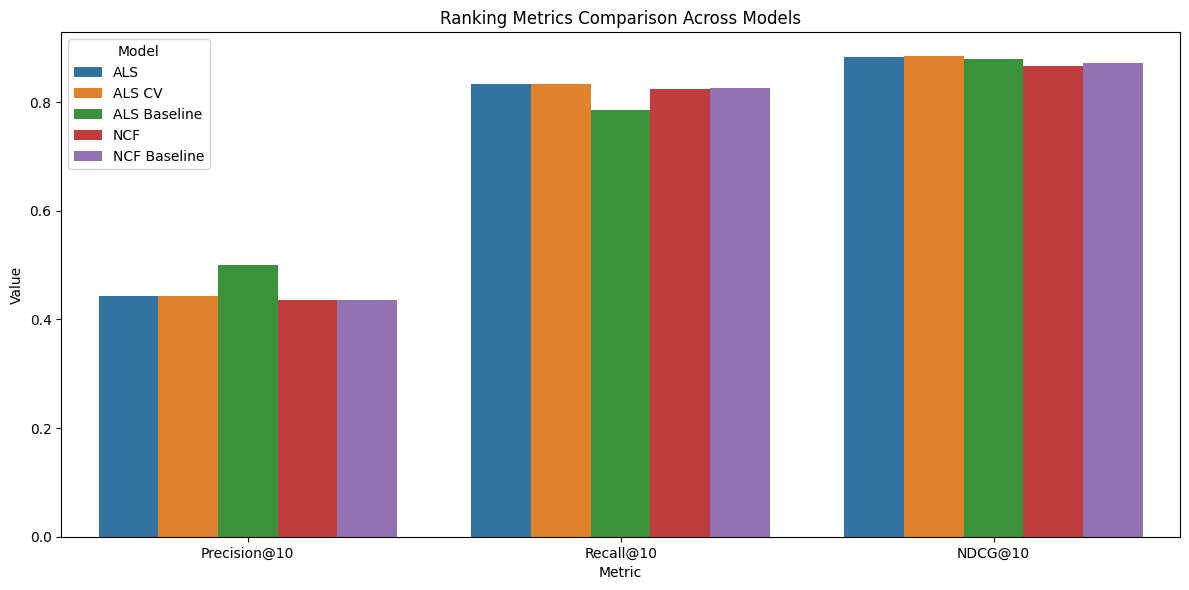

In [16]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def parse_all_ranking_metrics(file_paths):
    """Parse ranking metrics for all models from provided text files."""
    model_metrics = {}
    metric_names = ["Precision@10", "Recall@10", "NDCG@10"]

    for file_path in file_paths:
        with open(file_path, "r") as f:
            lines = f.readlines()
            current_model = None
            for line in lines:
                line = line.strip()
                model_match = re.match(r"^([\w\s]+)RMSE:", line)
                if model_match:
                    current_model = model_match.group(1).strip()
                    if current_model not in model_metrics:
                        model_metrics[current_model] = {}
                for metric in metric_names:
                    if f"{metric}:" in line and current_model:
                        val_match = re.search(rf"{metric}:\s*([\d.]+)", line)
                        if val_match:
                            model_metrics[current_model][metric] = float(
                                val_match.group(1))
    return model_metrics


def plot_ranking_metrics(metrics_dict):
    """Create a barplot from parsed ranking metrics."""
    df = pd.DataFrame([
        {"Model": model, "Metric": metric, "Value": value}
        for model, metrics in metrics_dict.items()
        for metric, value in metrics.items()
    ])

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Metric", y="Value", hue="Model")
    plt.title("Ranking Metrics Comparison Across Models")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.savefig("fixed_ranking_metrics.png")
    plt.show()


# Usage
ranking_metrics = parse_all_ranking_metrics([
    "als_evaluation_results.txt",
    "ncf_evaluation_results.txt"
])
plot_ranking_metrics(ranking_metrics)

In [17]:
# Cell 8: Clean Up
def cleanup():
    try:
        spark.stop()
        logging.info("Spark session closed.")
    except Exception as e:
        logging.error(f"Cleanup failed: {str(e)}")
        raise


cleanup()

2025-08-04 12:47:26,133 - INFO - Spark session closed.
2025-08-04 12:47:26,133 - INFO - Spark session closed.
